In [11]:
from pandas_datareader import data, wb
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import scipy as sp
import scipy.stats

from statsmodels.stats.stattools import durbin_watson as dw_test

# <font face="gotham" color="purple"> What is Autocorrelation? </font>

Recall that a classical linear regression model 
$$
Y_t = \beta_1 +\beta_2 X_t +u_t
$$

has an assumption
$$
E\left(u_{i} u_{j}\right)=0 \quad i \neq j
$$
i.e. disturbance terms are independent of each other. However, in many real situations, this assumption will not hold, especially in time series data. Many economic or financial time series data has a 'momentum', for instance, if we see a boost in consumer confidence in this month, it is more likely continue the momentum next month unless something unexpected happens. 

However if this assumption is violated, we have **autocorrelation** issue
$$
E\left(u_{i} u_{j}\right)\neq 0 \quad i \neq j
$$
There are many reasons why autocorrelation exists, but for now we don't care about the exact reason.

If we say a series is positively autocorrelated, it means correlation between successive values are positive, vice verse we call it negatively autorrelated. 

# <font face="gotham" color="purple"> AR And MA Processes </font>

If the disturbance term is generated by the process
$$
u_{t}=\rho u_{t-1}+\varepsilon_{t} \quad-1<\rho<1
$$
we call it a **First-Order Autoregression Process**, denoted $AR(1)$. And **innovation** $\varepsilon_{t}$ satisfies standard features of OLS disturbance term as below, and $\rho$ is coefficient of autocorrelation at lag $1$
$$
\begin{aligned}
E\left(\varepsilon_{t}\right) &=0 \\
\operatorname{Var}\left(\varepsilon_{t}\right) &=\sigma_{\varepsilon}^{2} \\
\operatorname{Cov}\left(\varepsilon_{t}, \varepsilon_{t+s}\right) &=0 \quad s \neq 0
\end{aligned}
$$
If $|\rho|<1$ we say that $AR(1)$ process is **stationary**, we'll get back to this topic in more details.

The main alternative is **moving average model** which is a weighted sum of current and previous values of $\varepsilon$'s, for instance $MA(2)$ is
$$
u_t = \lambda_0 \varepsilon_t+ \lambda_1 \varepsilon_{t-1}+ \lambda_2 \varepsilon_{t-2}
$$

# <font face="gotham" color="purple">Causes Of Autocorrelation</font>

## <font face="gotham" color="purple"> Model Misspecification</font>

In [111]:
df = pd.read_excel('Basic_Econometrics_practice_data.xlsx', sheet_name = 'Mortality_NI_WB_2019')
df.head()
df_mort = df[df['Series_Name']=='mortality_rate_per_1000']
df_NI = df[df['Series_Name']=='NI_perCap_2010constUSD']

In [118]:
reg_results = sp.stats.linregress(df_NI[2019], df_mort[2019])
Y_fit = reg_results[1]+reg_results[0]*df_NI[2019]
residuals = np.asarray(df_mort[2019])-np.asarray(Y_fit)

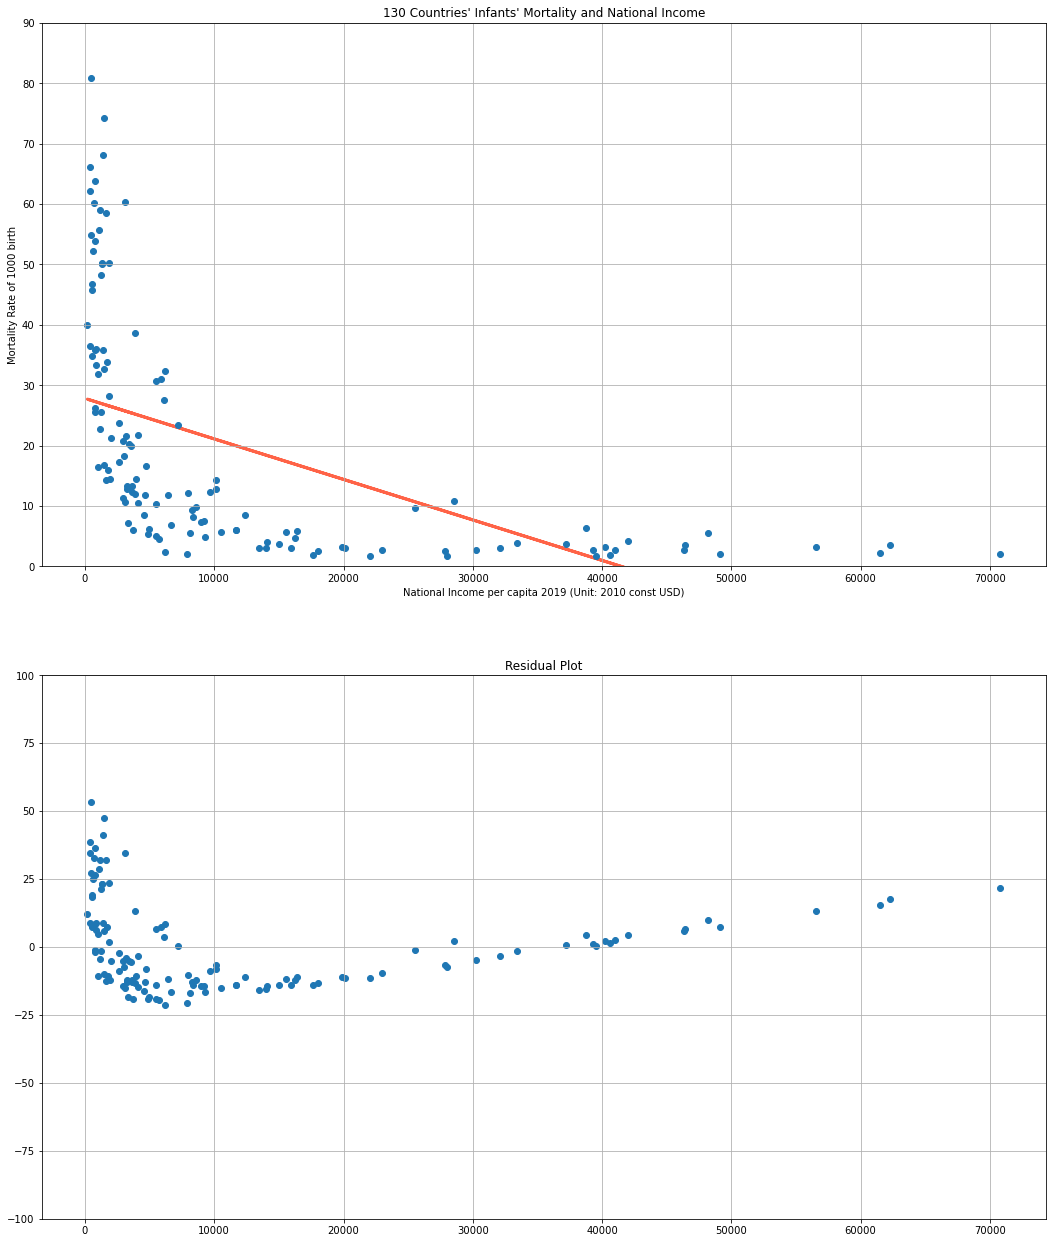

In [126]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (18, 22))
ax[0].scatter(df_NI[2019], df_mort[2019])
ax[0].plot(df_NI[2019], Y_fit, color = 'tomato', lw = 3, zorder =0)
ax[0].set_xlabel('National Income per capita 2019 (Unit: 2010 const USD)')
ax[0].set_title("130 Countries' Infants' Mortality and National Income")
ax[0].set_ylabel('Mortality Rate of 1000 birth')
ax[0].set_ylim([0, 90])
ax[0].grid()

ax[1].scatter(df_NI[2019], residuals)
ax[1].set_ylim([-100, 100])
ax[1].grid()
ax[1].set_title('Residual Plot')
plt.show()

## <font face="gotham" color="purple"> Omitted Variable Bias</font>

Be aware low $dw$ test might signal the omission of variable, but not vice versa, we can demonstrate with Monte Carlo simulation.

In [178]:
N = 100
beta1, beta2, beta3 = 3, 4, 5
X2 = np.arange(N)
dw_array_omit_X2, dw_array_omit_X3, dw_array = [], [], []
for i in range(10000):
    u = np.random.randn(N)
    X3 = np.random.rand(N)
    Y = beta1 + beta2*X2 + beta3*X3 + u
    df = pd.DataFrame([Y, X2, X3]).T
    df.columns = ['Y', 'X2', 'X3']
    model = smf.ols(formula = 'Y ~ X2', data = df)
    results = model.fit()
    dw_array_omit_X3.append(dw_test(results.resid))
    
    model = smf.ols(formula = 'Y ~ X3', data = df)
    results = model.fit()
    dw_array_omit_X2.append(dw_test(results.resid))
    
    model = smf.ols(formula = 'Y ~ X2 + X3', data = df)
    results = model.fit()
    dw_array.append(dw_test(results.resid))

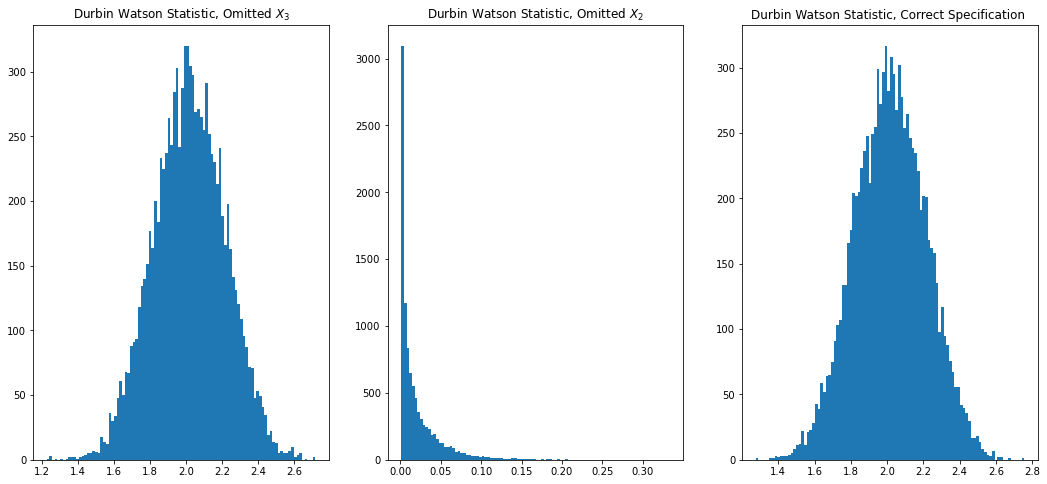

In [179]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (18, 8))
ax[0].hist(dw_array_omit_X3, bins = 100)
ax[0].set_title('Durbin Watson Statistic, Omitted $X_3$')
ax[1].hist(dw_array_omit_X2, bins = 100)
ax[1].set_title('Durbin Watson Statistic, Omitted $X_2$')
ax[2].hist(dw_array, bins = 100)
ax[2].set_title('Durbin Watson Statistic, Correct Specification ')
plt.show()

# <font face="gotham" color="purple"> Autocorrelation Test </font>

The standard test for first order autocorrelation is **Durbin-Watson Test**, it is one of standard output of OLS estimation. It is calculated by the formula
$$
dw=\frac{\sum_{t=2}^{T}\left(e_{t}-e_{t-1}\right)^{2}}{\sum_{t=1}^{T} e_{t}^{2}}
$$

where $e_t$ is residual at time $t$. 

As an example, we can reproduce the OLS estimation of disposable income and house price in China. 

In [39]:
df = pd.read_excel('Basic_Econometrics_practice_data.xlsx', sheet_name = 'CN_Cities_house_price')
model = smf.ols(formula='house_price ~ salary', data=df)
results = model.fit()

from statsmodels.stats.stattools import durbin_watson as dw_test

dw_test(results.resid)

0.9255117521586905

Or we can write our own Durbin-Watson function to verify the results

In [38]:
def durbin_watson_test(series):
    nomin = np.sum((series[1:] - series.shift(1).dropna())**2)
    denom = np.sum(series**2)
    return nomin/denom
durbin_watson_test(results.resid)

0.9255117521586905

But how to interpret this number? Some mathematical manipulations of Durbin-Watson's statistic will bring some insight
$$
dw=\frac{\sum_{t=2}^{T}\left(e_{t}-e_{t-1}\right)^{2}}{\sum_{t=1}^{T} e_{t}^{2}} = \frac{\sum_{t=2}^{T}\left(e^2_{t}-2e_te_{t-1}+e^2_{t-1}\right)}{\sum_{t=1}^{T} e_{t}^{2}} = \frac{\sum_{t=1}^Te_t^2}{\sum_{t=1}^Te_t^2}+\frac{\sum_{t=1}^Te_{t-1}^2}{\sum_{t=1}^Te_t^2}-2\frac{\sum_{t=1}^Te_te_{t-1}}{\sum_{t=1}^Te_t^2}
$$

If $T\rightarrow \infty$, the second term approaches $1$ infinitely and the third term $\frac{\sum_{t=1}^Te_te_{t-1}}{\sum_{t=1}^Te_t^2}$ equals $\rho$, because it is a simple OLS estimator of $\rho$. 

Therefore $dw \rightarrow 2-2\rho$ given $T\rightarrow \infty$.



If no autocorrelation, $\rho=0$, $dw$ should be $2$, if $\rho > .5$, i.e. strong positive autocorrelation, $dw$ will be close to $0$, or if $\rho>-.5$, i.e. strong negative autocorrelation, $dw$ will be close to $4$.

Because $dw$ statistic doesn't have critical value (due to some technical reason, critical value can't be calculated.) However, it is possible to know the upper and lower limit of $dw$, go search _Durbin Watson table_ on Google and click any of image that shows on top, or click <a href='https://www.real-statistics.com/statistics-tables/durbin-watson-table/'>here</a>.

In the data of flat price, number of observations is $25$ and number of independent variables is $1$, here are upper and lower limit from the table.
$$
d_L = 1.055\\
d_U = 1.210
$$
Our result $dw=0.9255$ is lower than lower limit, which suggests a rejection of null hypothesis $\rho=0$, why? Because it's too far away from $2$, if $dw$ is larger than upper limit, we fail to reject null hypothesis. If the $dw$ drops between lower and upper limit, just forget about it, no decisive conclusion. 

However, keep in mind that autocorrelation can also be attributed to model specification errors and we almost only care about autocorrelation issue in time series rather than cross sectional data.

Here is an example of exchange rate $EUR/USD$.

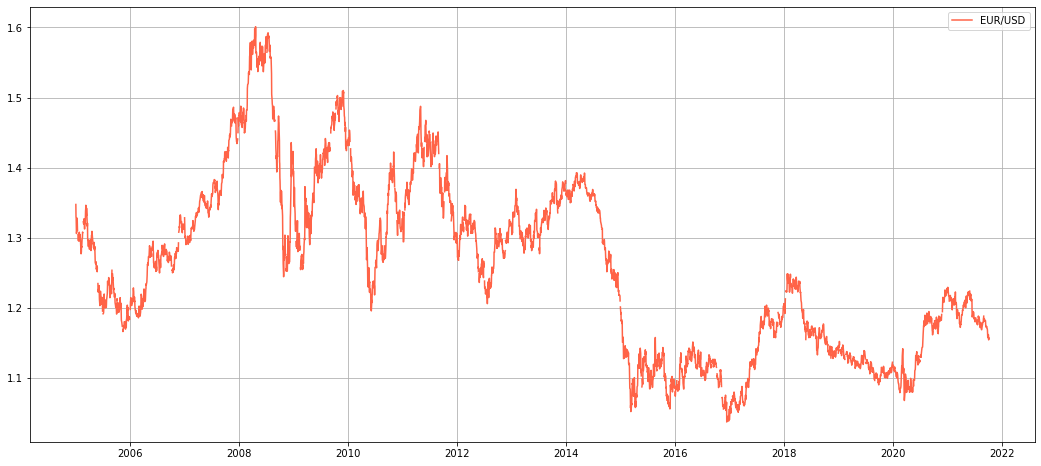

In [41]:
start = dt.datetime(2005, 1, 1)
end = dt.datetime.today()
EURUSD = pdr.data.DataReader('DEXUSEU', 'fred', start, end)

fig, ax = plt.subplots(figsize = (18, 8))
ax.plot(EURUSD, color = 'tomato', label = 'EUR/USD')
ax.legend()
ax.grid()
plt.show()

In [43]:
durbin_watson_test(EURUSD['DEXUSEU'])

3.206787081687621e-05

The $dw$ statistic is literally $0$, which means $\rho=1$, this shouldn't be a shocking result. Most of time sereis of assets price will show a strong first degree autocorrelation, this is why we like trading the trend or momentum. 

However, $dw$ test is mostly for testing residuals, here's another example that demonstrating highly autocorrelated residuals.

In [57]:
start = dt.datetime(2005, 1, 1)
end = dt.datetime.today()
df = pdr.data.DataReader(['A939RX0Q048SBEA','PRFI'], 'fred', start, end)
df.columns = ['real_GDP_perCap', 'priv_resid_fixInv']

In [58]:
df.head()

,real_GDP_perCap,priv_resid_fixInv
DATE,,
2005-01-01,50068.0,815.285
2005-04-01,50204.0,843.801
2005-07-01,50470.0,875.593
2005-10-01,50629.0,890.206
2006-01-01,51200.0,896.218


In [60]:
model = smf.ols(formula='real_GDP_perCap ~ priv_resid_fixInv', data=df)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        real_GDP_perCap   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     45.12
Date:                Fri, 15 Oct 2021   Prob (F-statistic):           5.82e-09
Time:                        20:12:49   Log-Likelihood:                -595.73
No. Observations:                  66   AIC:                             1195.
Df Residuals:                      64   BIC:                             1200.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          4.749e+04    880.09

# <font face="gotham" color="purple"> OLS Estimation With Presence Of Autocorrelation </font>

As in the case of heteroscedasticity, in the presence of autocorrelation the OLS estimatorsare still linear unbiased as well as consistent and asymptotically normally distributed, but they are no longer efficient (i.e., minimum variance).

First use a $AR(1)$ model to generate an autocorrelated series as our disturbance term
$$
u_{t}=\rho u_{t-1}+\varepsilon_{t}
$$
choose any $\rho$ fits your preference, here I use $.98$ 

In [82]:
T = 500
epsilon = 10*np.random.randn(T)
u = [100]
u_current = u[0]
rho = .98
for i in epsilon:
    u_next = rho * u_current + i
    u.append(u_next)
    u_current = u_next
u = u[1:]

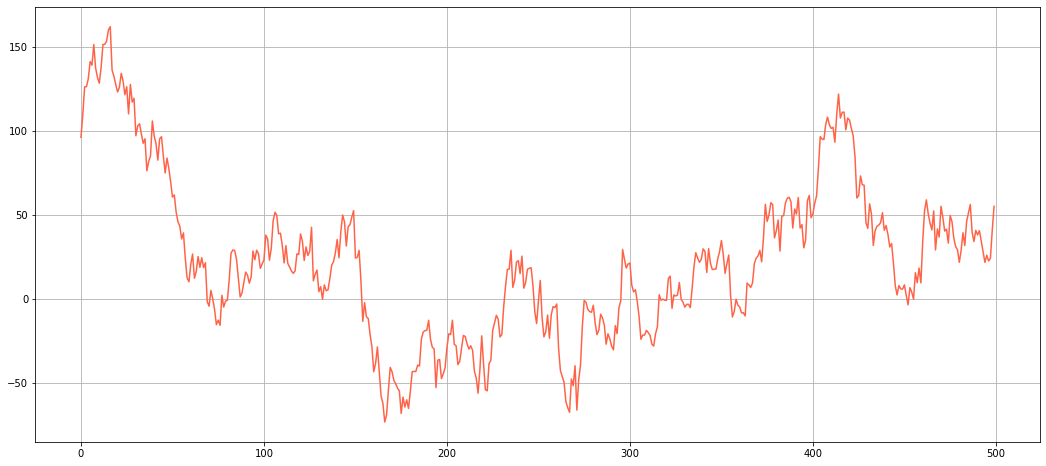

In [83]:
fig, ax = plt.subplots(figsize = (18, 8))
ax.plot(u, color = 'tomato')
ax.grid()
plt.show()

Then assume $X$ fixed at $1, 2, 3,..., T$ and define a true relationship as
$$
Y_t = 2 + 3 X_t + u_t
$$

In [98]:
X = np.arange(1, T+1)
Y = 2 + 3*X + u
df = pd.DataFrame([X, Y]).T
df.columns = ['X', 'Y']

In [100]:
model = smf.ols(formula='Y ~ X', data=df)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                 4.081e+04
Date:                Tue, 19 Oct 2021   Prob (F-statistic):               0.00
Time:                        19:42:55   Log-Likelihood:                -2637.9
No. Observations:                 500   AIC:                             5280.
Df Residuals:                     498   BIC:                             5288.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     32.5710      4.247      7.669      0.0

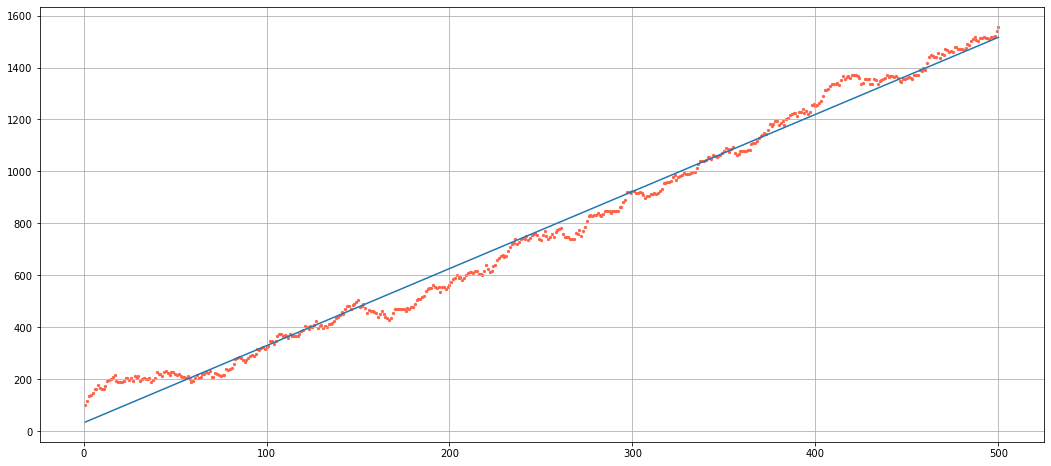

In [107]:
fig, ax = plt.subplots(figsize = (18, 8))
ax.scatter(X, Y, color = 'tomato', s = 5)
ax.plot(X, results.fittedvalues)
ax.grid()
plt.show()